## 加载 MNIST 数据集

In [1]:
# 不显示指定时，keras默认使用tensorflow的引擎，会打印“Using TensorFlow backend”
# keras支持多种引擎
from keras.datasets import mnist

# X： 60000个28*28的数组，数组元素是灰度值
# Y： 60000个样本对应的数字
(x_train, y_train), (x_test, y_test) = mnist.load_data('mnist/mnist.npz')

Using TensorFlow backend.


In [2]:
print(x_train.shape, type(x_train))
print(y_train.shape, type(y_train))

(60000, 28, 28) <class 'numpy.ndarray'>
(60000,) <class 'numpy.ndarray'>


## 数据处理：规范化

In [3]:
# 将图像本身从[28,28]转换为[784,]，即拉平为一维数组
# 训练集
X_train = x_train.reshape(60000, 784)
# 测试集
X_test = x_test.reshape(10000, 784)
# 查看维度信息
print(X_train.shape, type(X_train))
print(X_test.shape, type(X_test))

(60000, 784) <class 'numpy.ndarray'>
(10000, 784) <class 'numpy.ndarray'>


In [4]:
# 将数据类型转换为float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# 数据归一化，将数值从[0-255]归一化为[0.0,1.0]区间内的浮点数
X_train /= 255
X_test /= 255

## 统计训练数据中各标签数量

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 看看每个label有多少个样本
label, count = np.unique(y_train, return_counts=True)
print(label, count)

[0 1 2 3 4 5 6 7 8 9] [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


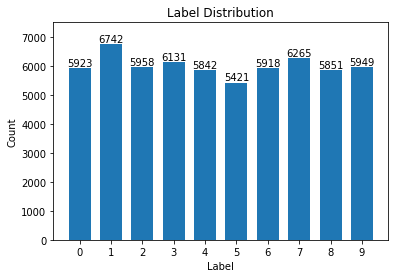

In [6]:
# 柱状图，横坐标是label，纵坐标是count，宽度是0.7，标题居中
# 横坐标刻度根据label来设置
# 纵坐标取值区间是[0,7500]
fig = plt.figure()
plt.bar(label, count, width = 0.7, align='center')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(label)
plt.ylim(0,7500)

# 在柱状图顶部显示纵坐标值
for a,b in zip(label, count):
    # 中心对称，水平对称，字体大小10，值是b
    plt.text(a, b, '%d' % b, ha='center', va='bottom',fontsize=10)

# 样本相对均匀，说明这个数据集是比较好的
plt.show()

## 数据处理：one-hot 编码

### 几种编码方式的对比

| Binary | Gray code | One-hot  |
| ------ | --------- | -------- |
| 000    | 000       | 00000001 |
| 001    | 001       | 00000010 |
| 010    | 011       | 00000100 |
| 011    | 010       | 00001000 |
| 100    | 110       | 00010000 |
| 101    | 111       | 00100000 |
| 110    | 101       | 01000000 |
| 111    | 100       | 10000000 |

### one-hot 应用
![](https://shanelynnwebsite-mid9n9g1q9y8tt.netdna-ssl.com/wp-content/uploads/2018/01/one-hot-word-embedding-vectors.png)

In [7]:
from keras.utils import np_utils

# y值一共有10个值（分成10类）
n_classes = 10 

# 训练集Y值
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes) #one-hot编码
print("Shape after one-hot encoding: ", Y_train.shape)

# 测试集Y值
Y_test = np_utils.to_categorical(y_test, n_classes)

Shape before one-hot encoding:  (60000,)
Shape after one-hot encoding:  (60000, 10)


In [8]:
print(y_train[0])
print(Y_train[0])

5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


## 使用 Keras sequential model 定义神经网络

### softmax 网络层

![](https://developers.google.com/machine-learning/crash-course/images/SoftmaxLayer.svg)

In [9]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation

# 线性定义神经网络层的高层API
# 在这个代码块定义了前向传播
model = Sequential()

# 第1层：全链接隐藏层、512个神经元，输入向量是784长度的向量，对应784个像素，激活层是RELU
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            

# 第2层：全链接隐藏层、512个神经元，输入用默认值（上一层的输出：W*X经过Relu激活后）
model.add(Dense(512))
model.add(Activation('relu'))

# 最后一层：10个神经元的全链接层，对应softmax的10个分类类别
model.add(Dense(10))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.


## 编译模型

[model.compile()](https://keras.io/models/sequential/#compile)

```python
compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
```

In [10]:
# 本质上是在做数据流图的反向传播
# optimizer：指定optimizer之后，这个代码块也定义了后向传播；adam有自适应超参数调整、比随机梯度下降效率更高
# loss：使用了交叉熵
# metrics：主要关注准确率
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# 到这一步，完整的数据流图已经定义好了

## 训练模型，并将指标保存到 history 中

[model.fit()](https://keras.io/models/sequential/#fit)

```python
fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None)
```

In [11]:
# 用底层API需要了解基础概念
# keras隐藏掉了一些底层的概念
history = model.fit(X_train, #样本特征
                    Y_train, #样本标签
                    batch_size=128, #每一步训练只输入128张图片
                    epochs=5, #一共遍历5次（每个样本都被训练5次）
                    verbose=2, #日志输出的复杂度
                    validation_data=(X_test, Y_test) #测试样本
                   ) 
#日志输出：训练集loss、准确率；测试集loss、准确率

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
 - 6s - loss: 0.2182 - acc: 0.9349 - val_loss: 0.1088 - val_acc: 0.9658
Epoch 2/5
 - 6s - loss: 0.0802 - acc: 0.9754 - val_loss: 0.0766 - val_acc: 0.9767
Epoch 3/5
 - 6s - loss: 0.0509 - acc: 0.9838 - val_loss: 0.0775 - val_acc: 0.9766
Epoch 4/5
 - 6s - loss: 0.0347 - acc: 0.9890 - val_loss: 0.0839 - val_acc: 0.9729
Epoch 5/5
 - 6s - loss: 0.0265 - acc: 0.9915 - val_loss: 0.0852 - val_acc: 0.9751


## 可视化指标

In [15]:
# 下面以字典的方式获取数据，字典key都封装在keras的model中
print(history.history)

{'val_loss': [0.10884380709528924, 0.07659384431568905, 0.07745792221873998, 0.08389661893583834, 0.08524727717414499], 'loss': [0.21817836205561955, 0.08021711114645004, 0.05094413233399391, 0.03465126579453548, 0.026466431617240112], 'val_acc': [0.9658, 0.9767, 0.9766, 0.9729, 0.9751], 'acc': [0.9349333333333333, 0.9753666666984558, 0.9837833333651225, 0.989, 0.9915]}


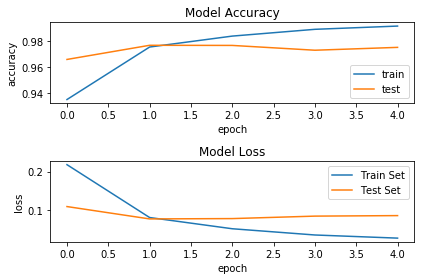

In [18]:
# 准确率变化情况
# 第一轮时测试集准确率达到很高水平，因为是在点1的模型参数预测点0的样本，所以准确率比较高
fig = plt.figure()
plt.subplot(2,1,1) #绘制子图
plt.plot(history.history['acc'])  #训练集准确率，绘制点
plt.plot(history.history['val_acc'])  #测试集准确率，绘制点
plt.title('Model Accuracy')  #标题
plt.ylabel('accuracy') #Y轴名称
plt.xlabel('epoch') #X轴名称
plt.legend(['train', 'test'], loc='lower right') #图例,参数1时训练集测试集的名称

# Loss值变化情况
# 开始时比较大，第一轮之后降低到比较低的水平
plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train Set', 'Test Set'], loc='upper right')
plt.tight_layout()

plt.show()

## 保存模型

[model.save()](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model)

You can use `model.save(filepath)` to save a Keras model into a single **HDF5 file** which will contain:

- the architecture of the model, allowing to re-create the model
- the weights of the model
- the training configuration (loss, optimizer)
- the state of the optimizer, allowing to resume training exactly where you left off.

You can then use `keras.models.load_model(filepath)` to reinstantiate your model. load_model will also take care of compiling the model using the saved training configuration (unless the model was never compiled in the first place).

In [19]:
import os
import tensorflow.gfile as gfile

# 保存文件的目录
save_dir = "./mnist/model/"
if gfile.Exists(save_dir):
    gfile.DeleteRecursively(save_dir)
gfile.MakeDirs(save_dir)

# HDF5文件格式，karas的格式，包含模型的格式，网络结构，参数，
# 训练配置（loss，optimizer等），optimizer的状态（用于继续训练、retrain等）
model_name = 'keras_mnist.h5'
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at ./mnist/model/keras_mnist.h5 


## 加载模型

In [20]:
from keras.models import load_model

# 先前保存的文件可以重新加载回来
mnist_model = load_model(model_path)

## 统计模型在测试集上的分类结果

In [21]:
# 对测试集样本进行预测，检查loss值以及metrics值
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss: {}".format(loss_and_metrics[0]))
print("Test Accuracy: {}%".format(loss_and_metrics[1]*100))

# 模型对测试集样本预测结果
predicted_classes = mnist_model.predict_classes(X_test)

# 预测正确、错误的样本
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print("Classified correctly count: {}".format(len(correct_indices)))
print("Classified incorrectly count: {}".format(len(incorrect_indices)))

Test Loss: 0.08524727754928609
Test Accuracy: 97.50999999999999%
Classified correctly count: 9751
Classified incorrectly count: 249


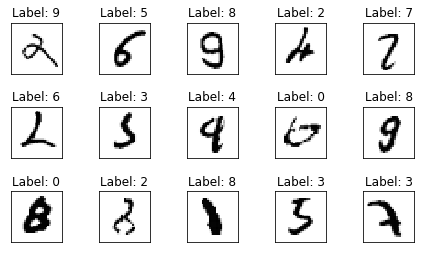

In [43]:
# 参照之前代码，把预测正确，错误的样本绘制出来
import matplotlib.pyplot as plt

pic_idx = 1
max_num = 15 #5*3 = 15
fig = plt.figure()
for i in incorrect_indices:
    plt.subplot(3,5,pic_idx) # 绘制前15个手写体数字，以3行5列子图形式展示
    plt.tight_layout() # 自动适配子图尺寸
    plt.imshow(x_test[i], cmap='Greys') # 使用灰色显示像素灰度值
    plt.title("Label: {}".format(predicted_classes[i])) # 设置标签为子图标题
    plt.xticks([]) # 删除x轴标记
    plt.yticks([]) # 删除y轴标记
    pic_idx += 1 
    if (pic_idx > max_num):
        break